
📁 Upload your loan prediction dataset (CSV format)
Expected files: train.csv (with Loan_Status) and test.csv (optional)
Required columns: Gender, Married, Dependents, Education, Self_Employed,
ApplicantIncome, CoapplicantIncome, LoanAmount, Loan_Amount_Term,
Credit_History, Property_Area, Loan_Status (in training data)


Saving test.csv to test (4).csv
Saving train.csv to train (4).csv
✅ 2 file(s) uploaded successfully!

📄 Processing test (4).csv: 367 rows, 12 columns
   Columns: ['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Property_Area']
   ℹ️  Test data identified (no Loan_Status column)

📄 Processing train (4).csv: 614 rows, 13 columns
   Columns: ['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status']
   ✅ Training data identified (has Loan_Status column)
   📊 Target distribution: {'Y': 422, 'N': 192}

🎯 Using training data: 614 rows, 13 columns
📝 Test data available: 367 rows, 12 columns

=== DATA PREPROCESSING ===
✅ Missing values handled. Remaining: 0
✅ New features created: TotalIncome, LoanAmount_log, TotalIncome_log
✅ Categori

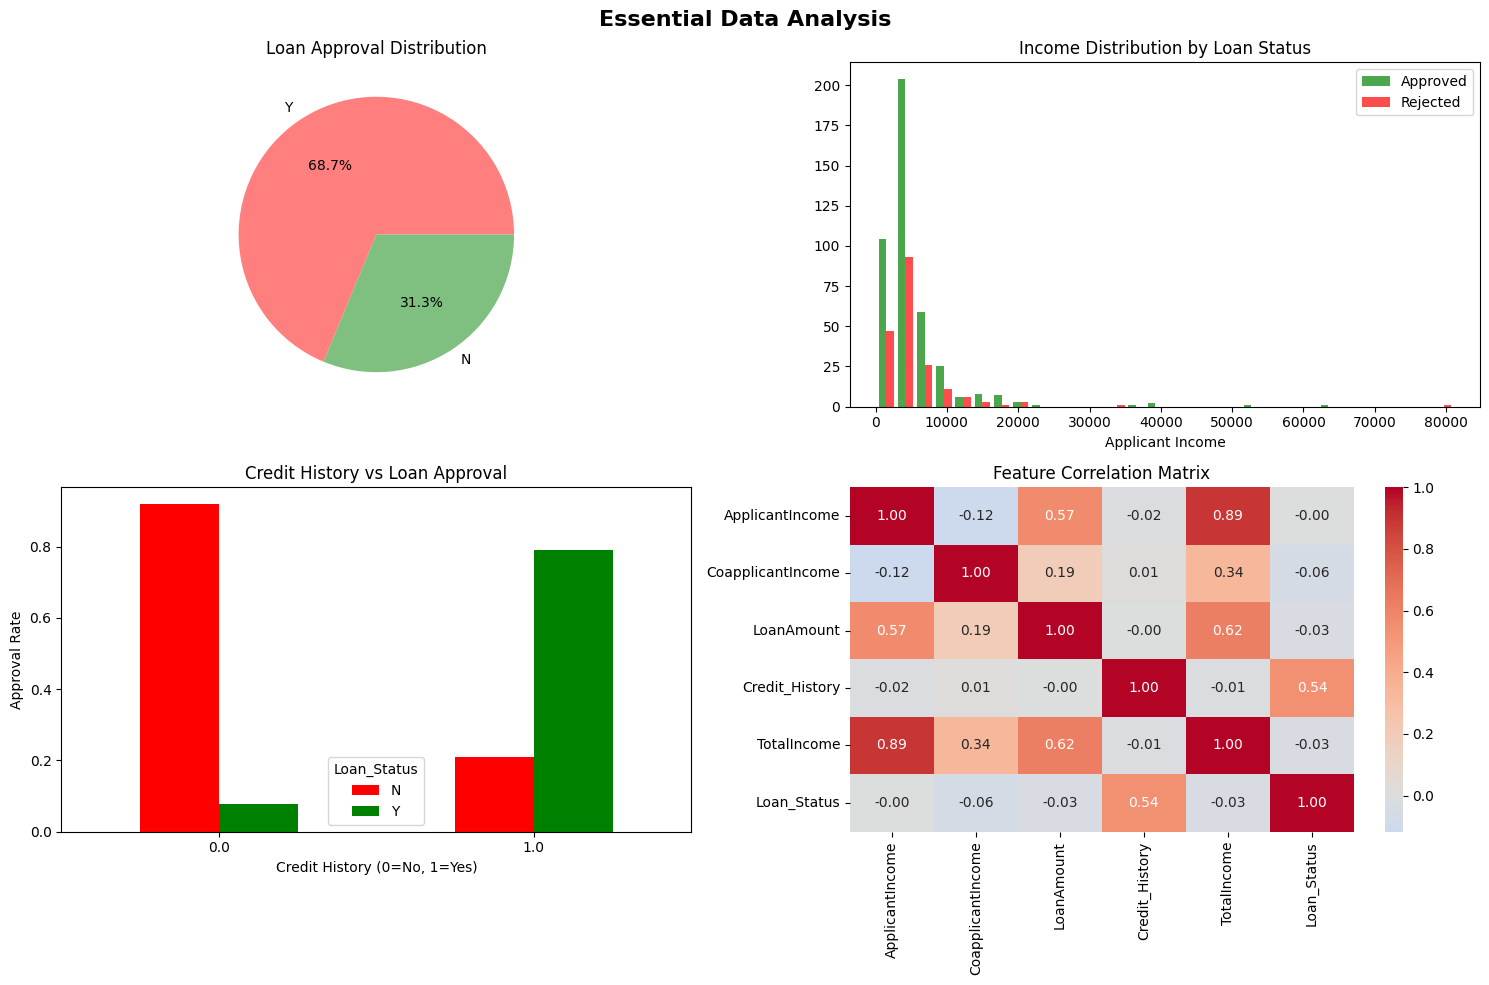

📊 Dataset Overview:
  • Total applications: 614
  • Approval rate: 68.7%
  • Average loan amount: $146k
  • Average applicant income: $5403

=== MODEL TRAINING ===
✅ Data split: 491 train, 123 test samples

🔸 Training Logistic Regression...
  • Accuracy: 0.8618
  • AUC Score: 0.8130

🔸 Training Random Forest...
  • Accuracy: 0.8537
  • AUC Score: 0.8435

=== MODEL EVALUATION ===


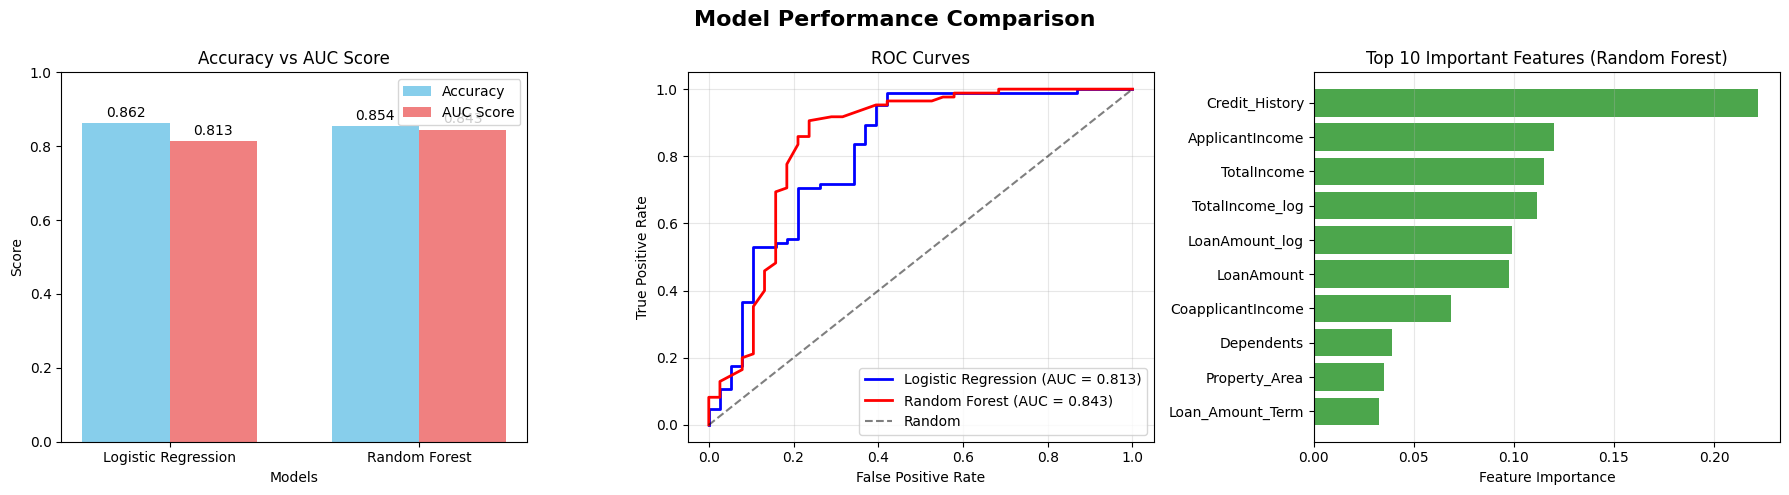


📊 MODEL COMPARISON SUMMARY:
Metric               Logistic Regression  Random Forest  
-------------------------------------------------------
Accuracy             0.8618               0.8537         
AUC Score            0.8130               0.8435         

🏆 BEST MODEL: Logistic Regression (Accuracy: 0.8618)

=== MAKING PREDICTIONS ON TEST DATA ===
✅ Predictions made for 367 test samples
📊 Logistic Regression - Predicted approvals: 308 (83.9%)
📊 Random Forest - Predicted approvals: 287 (78.2%)

Sample predictions:
    Loan_ID LR_Prediction  LR_Probability RF_Prediction  RF_Probability
0  LP001015             Y        0.843860             Y            0.82
1  LP001022             Y        0.840539             Y            1.00
2  LP001031             Y        0.855632             Y            0.79
3  LP001035             Y        0.851839             Y            0.86
4  LP001051             Y        0.652815             Y            0.53

💾 Predictions ready for submission!


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

# Google Colab specific imports
from google.colab import files
import io



def upload_dataset():
    """Upload and load the loan dataset"""
    print("\n📁 Upload your loan prediction dataset (CSV format)")
    print("Expected files: train.csv (with Loan_Status) and test.csv (optional)")
    print("Required columns: Gender, Married, Dependents, Education, Self_Employed,")
    print("ApplicantIncome, CoapplicantIncome, LoanAmount, Loan_Amount_Term,")
    print("Credit_History, Property_Area, Loan_Status (in training data)")

    uploaded = files.upload()

    if not uploaded:
        print("❌ No file uploaded!")
        return None, None

    train_df = None
    test_df = None

    print(f"✅ {len(uploaded)} file(s) uploaded successfully!")

    # Process each uploaded file
    for filename, file_content in uploaded.items():
        df = pd.read_csv(io.BytesIO(file_content))
        print(f"\n📄 Processing {filename}: {df.shape[0]} rows, {df.shape[1]} columns")
        print(f"   Columns: {list(df.columns)}")

        # Check if this file has the target variable
        if 'Loan_Status' in df.columns:
            train_df = df
            print(f"   ✅ Training data identified (has Loan_Status column)")
            print(f"   📊 Target distribution: {df['Loan_Status'].value_counts().to_dict()}")
        else:
            test_df = df
            print(f"   ℹ️  Test data identified (no Loan_Status column)")

    if train_df is None:
        print("\n❌ No training data found! Please upload a file with 'Loan_Status' column.")
        return None, None

    print(f"\n🎯 Using training data: {train_df.shape[0]} rows, {train_df.shape[1]} columns")
    if test_df is not None:
        print(f"📝 Test data available: {test_df.shape[0]} rows, {test_df.shape[1]} columns")

    return train_df, test_df

def preprocess_data(df):
    """Clean and preprocess the data"""
    print("\n=== DATA PREPROCESSING ===")

    # Handle missing values
    df['LoanAmount'].fillna(df['LoanAmount'].median(), inplace=True)
    df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mode()[0], inplace=True)
    df['Credit_History'].fillna(df['Credit_History'].mode()[0], inplace=True)
    df['Gender'].fillna(df['Gender'].mode()[0], inplace=True)
    df['Married'].fillna(df['Married'].mode()[0], inplace=True)
    df['Dependents'].fillna(df['Dependents'].mode()[0], inplace=True)
    df['Self_Employed'].fillna(df['Self_Employed'].mode()[0], inplace=True)

    print(f"✅ Missing values handled. Remaining: {df.isnull().sum().sum()}")

    # Feature Engineering
    df['TotalIncome'] = df['ApplicantIncome'] + df['CoapplicantIncome']
    df['LoanAmount_log'] = np.log(df['LoanAmount'])
    df['TotalIncome_log'] = np.log(df['TotalIncome'] + 1)
    print("✅ New features created: TotalIncome, LoanAmount_log, TotalIncome_log")

    # Encode categorical variables
    le_dict = {}
    categorical_cols = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']

    for col in categorical_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        le_dict[col] = le

    print("✅ Categorical variables encoded")
    return df, le_dict

def exploratory_analysis(df):
    """Essential exploratory data analysis with key visualizations"""
    print("\n=== EXPLORATORY DATA ANALYSIS ===")

    # Create 4 essential plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Essential Data Analysis', fontsize=16, fontweight='bold')

    # 1. Target distribution
    target_counts = df['Loan_Status'].value_counts()
    axes[0, 0].pie(target_counts.values, labels=target_counts.index, autopct='%1.1f%%',
                   colors=['#ff7f7f', '#7fbf7f'])
    axes[0, 0].set_title('Loan Approval Distribution')

    # 2. Income distribution by loan status
    approved = df[df['Loan_Status'] == 'Y']['ApplicantIncome']
    rejected = df[df['Loan_Status'] == 'N']['ApplicantIncome']
    axes[0, 1].hist([approved, rejected], bins=30, alpha=0.7,
                    label=['Approved', 'Rejected'], color=['green', 'red'])
    axes[0, 1].set_title('Income Distribution by Loan Status')
    axes[0, 1].set_xlabel('Applicant Income')
    axes[0, 1].legend()

    # 3. Credit History Impact
    credit_impact = pd.crosstab(df['Credit_History'], df['Loan_Status'], normalize='index')
    credit_impact.plot(kind='bar', ax=axes[1, 0], color=['red', 'green'])
    axes[1, 0].set_title('Credit History vs Loan Approval')
    axes[1, 0].set_xlabel('Credit History (0=No, 1=Yes)')
    axes[1, 0].set_ylabel('Approval Rate')
    axes[1, 0].tick_params(axis='x', rotation=0)

    # 4. Correlation heatmap (key features only)
    key_features = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Credit_History', 'TotalIncome']
    corr_data = df[key_features + ['Loan_Status']].copy()
    corr_data['Loan_Status'] = corr_data['Loan_Status'].map({'Y': 1, 'N': 0})

    sns.heatmap(corr_data.corr(), annot=True, cmap='coolwarm', center=0,
                ax=axes[1, 1], fmt='.2f')
    axes[1, 1].set_title('Feature Correlation Matrix')

    plt.tight_layout()
    plt.show()

    # Print key statistics
    approval_rate = (df['Loan_Status'] == 'Y').mean()
    print(f"📊 Dataset Overview:")
    print(f"  • Total applications: {len(df)}")
    print(f"  • Approval rate: {approval_rate:.1%}")
    print(f"  • Average loan amount: ${df['LoanAmount'].mean():.0f}k")
    print(f"  • Average applicant income: ${df['ApplicantIncome'].mean():.0f}")

def train_models(df):
    """Train and evaluate Logistic Regression and Random Forest models"""
    print("\n=== MODEL TRAINING ===")

    # Prepare features and target
    feature_cols = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
                   'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term',
                   'Credit_History', 'Property_Area', 'TotalIncome', 'LoanAmount_log', 'TotalIncome_log']

    X = df[feature_cols]
    y = df['Loan_Status'].map({'Y': 1, 'N': 0})

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    print(f"✅ Data split: {len(X_train)} train, {len(X_test)} test samples")

    # Scale features for Logistic Regression
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 1. Logistic Regression
    print("\n🔸 Training Logistic Regression...")
    lr_model = LogisticRegression(random_state=42, max_iter=1000)
    lr_model.fit(X_train_scaled, y_train)

    lr_pred = lr_model.predict(X_test_scaled)
    lr_proba = lr_model.predict_proba(X_test_scaled)[:, 1]
    lr_accuracy = accuracy_score(y_test, lr_pred)
    lr_auc = roc_auc_score(y_test, lr_proba)

    print(f"  • Accuracy: {lr_accuracy:.4f}")
    print(f"  • AUC Score: {lr_auc:.4f}")

    # 2. Random Forest
    print("\n🔸 Training Random Forest...")
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    rf_pred = rf_model.predict(X_test)
    rf_proba = rf_model.predict_proba(X_test)[:, 1]
    rf_accuracy = accuracy_score(y_test, rf_pred)
    rf_auc = roc_auc_score(y_test, rf_proba)

    print(f"  • Accuracy: {rf_accuracy:.4f}")
    print(f"  • AUC Score: {rf_auc:.4f}")

    return {
        'models': {'lr': lr_model, 'rf': rf_model},
        'predictions': {'lr': lr_pred, 'rf': rf_pred},
        'probabilities': {'lr': lr_proba, 'rf': rf_proba},
        'metrics': {
            'lr': {'accuracy': lr_accuracy, 'auc': lr_auc},
            'rf': {'accuracy': rf_accuracy, 'auc': rf_auc}
        },
        'test_data': (X_test, y_test),
        'scaler': scaler,
        'features': feature_cols
    }

def evaluate_models(results):
    """Create essential model comparison visualizations"""
    print("\n=== MODEL EVALUATION ===")

    # Create 3 key evaluation plots
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

    # 1. Accuracy and AUC Comparison
    models = ['Logistic Regression', 'Random Forest']
    accuracies = [results['metrics']['lr']['accuracy'], results['metrics']['rf']['accuracy']]
    aucs = [results['metrics']['lr']['auc'], results['metrics']['rf']['auc']]

    x = np.arange(len(models))
    width = 0.35

    axes[0].bar(x - width/2, accuracies, width, label='Accuracy', color='skyblue')
    axes[0].bar(x + width/2, aucs, width, label='AUC Score', color='lightcoral')
    axes[0].set_xlabel('Models')
    axes[0].set_ylabel('Score')
    axes[0].set_title('Accuracy vs AUC Score')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(models)
    axes[0].legend()
    axes[0].set_ylim(0, 1)

    # Add value labels
    for i, (acc, auc) in enumerate(zip(accuracies, aucs)):
        axes[0].text(i - width/2, acc + 0.01, f'{acc:.3f}', ha='center', va='bottom')
        axes[0].text(i + width/2, auc + 0.01, f'{auc:.3f}', ha='center', va='bottom')

    # 2. ROC Curves
    y_test = results['test_data'][1]
    lr_fpr, lr_tpr, _ = roc_curve(y_test, results['probabilities']['lr'])
    rf_fpr, rf_tpr, _ = roc_curve(y_test, results['probabilities']['rf'])

    axes[1].plot(lr_fpr, lr_tpr, label=f'Logistic Regression (AUC = {results["metrics"]["lr"]["auc"]:.3f})',
                linewidth=2, color='blue')
    axes[1].plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {results["metrics"]["rf"]["auc"]:.3f})',
                linewidth=2, color='red')
    axes[1].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('ROC Curves')
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    # 3. Feature Importance (Random Forest only)
    feature_importance = pd.DataFrame({
        'feature': results['features'],
        'importance': results['models']['rf'].feature_importances_
    }).sort_values('importance', ascending=True).tail(10)

    axes[2].barh(feature_importance['feature'], feature_importance['importance'], color='green', alpha=0.7)
    axes[2].set_xlabel('Feature Importance')
    axes[2].set_title('Top 10 Important Features (Random Forest)')
    axes[2].grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print comparison summary
    print(f"\n📊 MODEL COMPARISON SUMMARY:")
    print(f"{'Metric':<20} {'Logistic Regression':<20} {'Random Forest':<15}")
    print("-" * 55)
    print(f"{'Accuracy':<20} {results['metrics']['lr']['accuracy']:<20.4f} {results['metrics']['rf']['accuracy']:<15.4f}")
    print(f"{'AUC Score':<20} {results['metrics']['lr']['auc']:<20.4f} {results['metrics']['rf']['auc']:<15.4f}")

    # Determine winner
    if results['metrics']['rf']['accuracy'] > results['metrics']['lr']['accuracy']:
        winner = "Random Forest"
        winner_acc = results['metrics']['rf']['accuracy']
    else:
        winner = "Logistic Regression"
        winner_acc = results['metrics']['lr']['accuracy']

    print(f"\n🏆 BEST MODEL: {winner} (Accuracy: {winner_acc:.4f})")

def predict_test_data(models, scaler, encoders, train_df, test_df, feature_cols):
    """Make predictions on test data if available"""
    print(f"\n=== MAKING PREDICTIONS ON TEST DATA ===")

    # Preprocess test data
    test_processed = test_df.copy()

    # Handle missing values using training data statistics
    for col in ['LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Gender', 'Married', 'Dependents', 'Self_Employed']:
        if col in test_processed.columns and test_processed[col].isnull().any():
            if col in ['LoanAmount']:
                fill_value = train_df[col].median()
            else:
                fill_value = train_df[col].mode()[0]
            test_processed[col].fillna(fill_value, inplace=True)

    # Feature engineering
    test_processed['TotalIncome'] = test_processed['ApplicantIncome'] + test_processed['CoapplicantIncome']
    test_processed['LoanAmount_log'] = np.log(test_processed['LoanAmount'])
    test_processed['TotalIncome_log'] = np.log(test_processed['TotalIncome'] + 1)

    # Encode categorical variables
    for col, encoder in encoders.items():
        if col in test_processed.columns:
            # Handle unseen categories
            test_processed[col] = test_processed[col].astype(str)
            mask = test_processed[col].isin(encoder.classes_)
            test_processed.loc[mask, col] = encoder.transform(test_processed.loc[mask, col])
            # For unseen categories, use the most frequent class
            test_processed.loc[~mask, col] = encoder.transform([encoder.classes_[0]])[0]

    # Prepare features
    X_test = test_processed[feature_cols]
    X_test_scaled = scaler.transform(X_test)

    # Make predictions with both models
    lr_pred = models['lr'].predict(X_test_scaled)
    lr_proba = models['lr'].predict_proba(X_test_scaled)[:, 1]

    rf_pred = models['rf'].predict(X_test)
    rf_proba = models['rf'].predict_proba(X_test)[:, 1]

    # Create results dataframe
    results_df = pd.DataFrame({
        'Loan_ID': test_df['Loan_ID'] if 'Loan_ID' in test_df.columns else range(len(test_df)),
        'LR_Prediction': ['Y' if p == 1 else 'N' for p in lr_pred],
        'LR_Probability': lr_proba,
        'RF_Prediction': ['Y' if p == 1 else 'N' for p in rf_pred],
        'RF_Probability': rf_proba
    })

    print(f"✅ Predictions made for {len(test_df)} test samples")
    print(f"📊 Logistic Regression - Predicted approvals: {sum(lr_pred)} ({sum(lr_pred)/len(lr_pred)*100:.1f}%)")
    print(f"📊 Random Forest - Predicted approvals: {sum(rf_pred)} ({sum(rf_pred)/len(rf_pred)*100:.1f}%)")
    print(f"\nSample predictions:")
    print(results_df.head())

    return results_df

def main():
    """Main execution function"""
    try:
        # Step 1: Upload datasets
        train_df, test_df = upload_dataset()
        if train_df is None:
            return

        # Step 2: Preprocess training data
        train_processed, encoders = preprocess_data(train_df)

        # Step 3: Exploratory analysis
        exploratory_analysis(train_processed)

        # Step 4: Train models
        results = train_models(train_processed)

        # Step 5: Evaluate models
        evaluate_models(results)

        # Step 6: Make predictions on test data if available
        if test_df is not None:
            predictions = predict_test_data(
                results['models'],
                results['scaler'],
                encoders,
                train_df,
                test_df,
                results['features']
            )
            print(f"\n💾 Predictions ready for submission!")



    except Exception as e:
        print(f"❌ Error: {str(e)}")
        print(f"\n🔧 Debugging info:")
        if 'train_df' in locals():
            print(f"Training data columns: {list(train_df.columns)}")
        import traceback
        traceback.print_exc()

# Run the analysis
if __name__ == "__main__":
    main()